In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import scipy
import random
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [24]:
resize = 224  # input image size
learning_rate = 1e-4
seed = 107
# define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 17
BS = 64
# dir_mask = 'drive/MyDrive/content/mask_dataset/Dataset/with_mask'
# dir_inc_mask = 'drive/MyDrive/content/mask_dataset/Dataset/mask_weared_incorrect'
# dir_nomask = 'drive/MyDrive/content/mask_dataset/Dataset/without_mask'
# TRAIN_DIR = 'drive/MyDrive/content/mask_dataset/Dataset'

dir_mask = "./mask_dataset/with_mask/"
dir_inc_mask = "./mask_dataset/mask_weared_incorrect/"
dir_nomask = "./mask_dataset/without_mask/"
TRAIN_DIR = "./mask_dataset"

assert os.path.exists(dir_mask), "Could not find" + dir_mask
assert os.path.exists(dir_inc_mask), "Could not find" + dir_inc_mask
assert os.path.exists(dir_nomask), "Could not find" + dir_nomask

100%|██████████| 3/3 [00:00<00:00, 152.41it/s]


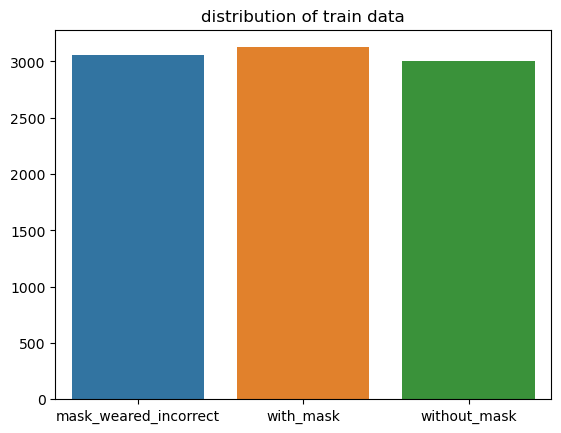

9189


100%|██████████| 3005/3005 [00:03<00:00, 983.18it/s] 


In [25]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(train_exm)

# Joining code starts here
# CATEGORIES = ["with_mask", "mask_weared_incorrect", "without_mask"]
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(c)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [26]:
len(labels)


9189

In [27]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'mask_weared_incorrect': 3058, 'with_mask': 3126, 'without_mask': 3005}

In [28]:
# Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [29]:
AugmentedData = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [30]:
# define the model
baseModel = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
baseModel.summary()

# construct the head of the model that will be placed on top of the
# the base model (A simple CNN as the Head model)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [31]:
# divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

Shape of x_train: (7351, 224, 224, 3)
Shape of y_train: (7351, 3)

Shape of x_test: (1838, 224, 224, 3)
Shape of y_test: (1838, 3)


In [32]:
# Complie the model and train it
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print(
    """[INFO] compiling model...
[INFO] training head..."""
)


# train the head of the network
H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
)  # Here we sets weights to each class.
# Class having high weight will be considered more importat while training

[INFO] compiling model...
[INFO] training head...
Epoch 1/17


2023-08-12 23:56:13.696437: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


114/114 [==============================] - 67s 555ms/step - loss: 0.5295 - accuracy: 0.7855 - val_loss: 0.2833 - val_accuracy: 0.8776
Epoch 2/17
114/114 [==============================] - 57s 497ms/step - loss: 0.2475 - accuracy: 0.9064 - val_loss: 0.2240 - val_accuracy: 0.9053
Epoch 3/17
114/114 [==============================] - 53s 460ms/step - loss: 0.1914 - accuracy: 0.9280 - val_loss: 0.2532 - val_accuracy: 0.8955
Epoch 4/17
114/114 [==============================] - 52s 452ms/step - loss: 0.1603 - accuracy: 0.9420 - val_loss: 0.1689 - val_accuracy: 0.9293
Epoch 5/17
114/114 [==============================] - 54s 469ms/step - loss: 0.1550 - accuracy: 0.9437 - val_loss: 0.1833 - val_accuracy: 0.9195
Epoch 6/17
114/114 [==============================] - 51s 448ms/step - loss: 0.1374 - accuracy: 0.9510 - val_loss: 0.1526 - val_accuracy: 0.9434
Epoch 7/17
114/114 [==============================] - 50s 441ms/step - loss: 0.1385 - accuracy: 0.9505 - val_loss: 0.1498 - val_accuracy: 0.9

[INFO] evaluating network...
29/29 [==============================] - 10s 295ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       612
           1       0.93      0.98      0.95       625
           2       0.96      0.98      0.97       601

    accuracy                           0.96      1838
   macro avg       0.96      0.96      0.96      1838
weighted avg       0.96      0.96      0.96      1838



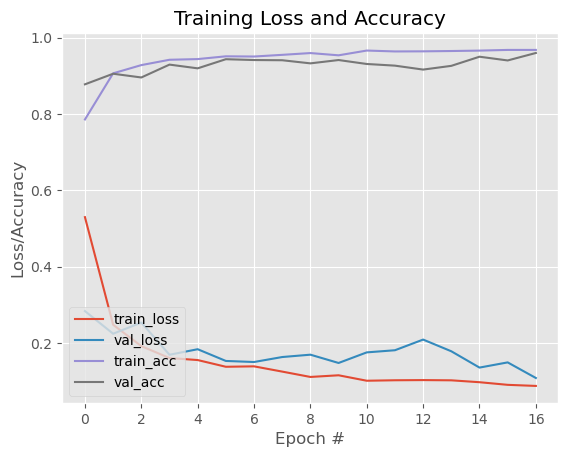

In [33]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [34]:
model.save("my_mask_detector_1.model", save_format="h5")


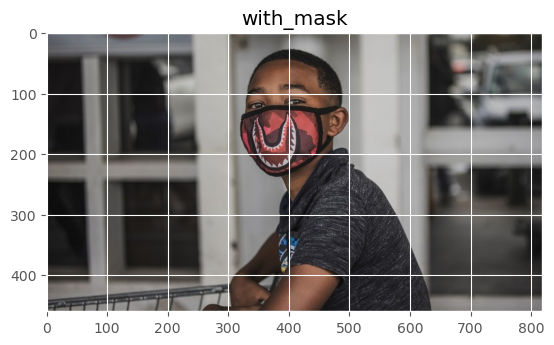

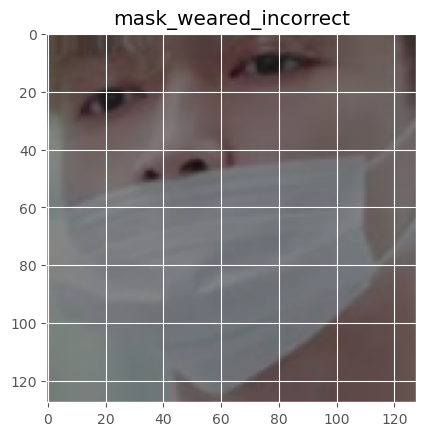

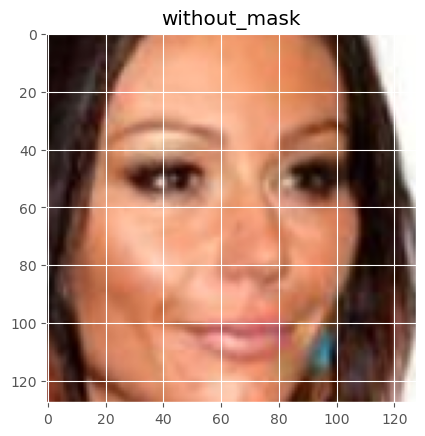

In [46]:
image01 = Image.open("/Users/inyourdream/CODE/Test/CVPR/FINAL/mask_dataset/with_mask/0018.jpg")
image02 = Image.open("/Users/inyourdream/CODE/Test/CVPR/FINAL/mask_dataset/mask_weared_incorrect/42.png")
image03 = Image.open("/Users/inyourdream/CODE/Test/CVPR/FINAL/mask_dataset/without_mask/507.png")

plt.figure("image01")
plt.title("with_mask")
plt.imshow(image01)

plt.figure("image02")
plt.title("mask_weared_incorrect")
plt.imshow(image02)

plt.figure("image03")
plt.title("without_mask")
plt.imshow(image03)

In [48]:
image01 = cv2.resize(
    cv2.imread(
        "/Users/inyourdream/CODE/Test/CVPR/FINAL/mask_dataset/with_mask/0018.jpg"
    ),
    (resize, resize),
)
image01 = image01.astype("float") / 255.0
image01 = image01.reshape((1, image01.shape[0], image01.shape[1], image01.shape[2]))

image02 = cv2.resize(
    cv2.imread(
        "/Users/inyourdream/CODE/Test/CVPR/FINAL/mask_dataset/mask_weared_incorrect/42.png"
    ),
    (resize, resize),
)
image02 = image02.astype("float") / 255.0
image02 = image02.reshape((1, image02.shape[0], image02.shape[1], image02.shape[2]))

image03 = cv2.resize(
    cv2.imread(
        "/Users/inyourdream/CODE/Test/CVPR/FINAL/mask_dataset/without_mask/507.png"
    ),
    (resize, resize),
)
image03 = image03.astype("float") / 255.0
image03 = image03.reshape((1, image03.shape[0], image03.shape[1], image03.shape[2]))


labelz = ("mask_weared_incorrect", "with_mask", "without_mask")

predict = model.predict(image01, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image02, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image03, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

1/1 [==============================] - 1s 1s/step
with_mask
1/1 [==============================] - 0s 26ms/step
mask_weared_incorrect
1/1 [==============================] - 0s 58ms/step
without_mask
